# Practical Data Science: 1st Assignment 
This is my code for the 1st assignment of the course Practical Data Science

###  First some imports

In [1]:
import tweepy
import requests
from bs4 import BeautifulSoup
from tweepy import Cursor
from datetime import datetime, date, time, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Part 1: Scraping Twitter Accounts
### 1.1 Connect to Twitter
* Program connects to Twitter app by getting the configuration data from the "twitter_config.py" file
* Then searches for trending topics in the area of Athens and prints the first ten of them


In [2]:
#importing configuration file
from twitter_config import config

#connecting to Twitter
auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
auth.set_access_token(config['access_token'], config['access_token_secret'])

api = tweepy.API(auth)

#setting search geo-id
athens_id = 946738

trends_list = api.trends_place(id=athens_id)[0]['trends']

#printing top 10 trends
for i in range(0,10):
    print(trends_list[i]['name'])

#adinamoskrikosgr
#annitakoita
#PAOKPAO
#aekatr
#μεταναστευτικο
Γιαννιτσα
κυριακης
φολεγανδρο
Καλη Κυριακη
σαγκαη


### 1.2 Username Scraping
* Scraping 49 Twitter usernames from Business Insider webpage by:
    * Get the html code of the page
    * Get the usernames from the \< p \> tag
    * Keep only the part that is after the string "Handle", which is where the usernames are located
* Usernames are put in the usernames list

In [3]:
page = requests.get("https://www.businessinsider.com/uk-politics-twitter-accounts-2016-8?")
html = page.content
soup = BeautifulSoup(html, 'html.parser')

results = soup.find_all("p")
usernames = []

for result in results:
    if "Handle" in result.get_text():
        usernames.append(result.get_text()[8:])


### 1.3 Fetch Tweets
* Using the list of usernames to fetch recent tweets
    * Set the stopping point at 24 hours
    * Print the username along with the count of tweets

In [4]:
#stopping point is calculated by the current time minus 24 hours
stop_point = datetime.utcnow() - timedelta(hours = 24)
tweet_count = 0

for username in usernames:
    try:
        for status in Cursor(api.user_timeline, id = username, count = 100).items():
            if status.created_at < stop_point:
                break
            else:
                    tweet_count += 1   
        print("Total number of tweets in the last 24hrs from", username, ":", tweet_count)
        tweet_count = 0
        print("-------------------------------------------------------------------")

    except:
        print("Could not fetch", username)
        print("-------------------------------------------------------------------")

    

Total number of tweets in the last 24hrs from @Tom_Slater_ : 0
-------------------------------------------------------------------
Total number of tweets in the last 24hrs from @MattSingh_ : 28
-------------------------------------------------------------------
Total number of tweets in the last 24hrs from @asabenn : 2
-------------------------------------------------------------------
Total number of tweets in the last 24hrs from @robfordmancs : 67
-------------------------------------------------------------------
Total number of tweets in the last 24hrs from @LadPolitics : 4
-------------------------------------------------------------------
Total number of tweets in the last 24hrs from @samgadjones : 0
-------------------------------------------------------------------
Total number of tweets in the last 24hrs from @PaulbernalUK : 87
-------------------------------------------------------------------
Total number of tweets in the last 24hrs from @youngvulgarian : 31
----------------

 ## Part 2: Processing Twitter accounts
 ### 2.1 Scrape and Put in a `DataFrame`
 

#### Solution 1
* Directly from the html page to data frame

In [5]:
#parsing page to dadtaframe
df_raw = pd.read_html('https://www.mpsontwitter.co.uk/list')
df1 = df_raw[1].copy()

#deleting and renaming columns
del df1["Unnamed: 0"], df1["Unnamed: 1"], df1["New Followers"], df1["Unnamed: 8"], df1["Unnamed: 9"]
df1.columns = ["name", "username", "constituency", "party", "num_followers"]

df1.head()

,name,username,constituency,party,num_followers
0,Adam Afriyie,@AdamAfriyie,Windsor,Conservative,14967
1,Alan Duncan,@AlanDuncanMP,Rutland and Melton,Conservative,26109
2,Alan Mak,@AlanMakMP,Havant,Conservative,8349
3,Alberto Costa,@AlbertoCostaMP,South Leicestershire,Conservative,9003
4,Alec Shelbrooke,@AlecShelbrooke,Elmet and Rothwell,Conservative,15108


#### Solution 2

* Parsing the html code of the given website
 * Fisrt, get the contents of each row of the table that we want to put in the dataframe and then, the contents of each cell
 * Creating a list with sublists. Each sublist represents a row of the dataframe

In [6]:
#Parsing the html of given website
page = requests.get('https://www.mpsontwitter.co.uk/list')
soup = BeautifulSoup(page.content, 'html.parser')

#Getting every row of table
rows = soup.find_all("tr")

#Getting the contents of all cells and putting them in lists
text = []
i = 0
for row in rows:
    cells = row.find_all("td")
    text.append([])
    for cell in cells:
        text[i].append(cell.get_text().splitlines())
    i += 1

#Removing empty lists and merging sublists from .splitlines() -- now each sublist will be a row of the dataframe
text = [x for x in text if x != []]

concat_list = []
for a in text:
    concat_list.append([j for i in a for j in i])



* Creating the dataframe
    * Using the concat_list
    * Deleting unwanted columns
    * Renaming columns   
    * Changing "num_followers" to integer

In [7]:
#dataframe from concat_list
df = pd.DataFrame(concat_list)

#removing unwanted columns
del df[0],df[6]

#renaming columns
df.columns=["name", "username", "constituency", "party", "num_followers"]

#changing data type of num_followers
df["num_followers"]=df["num_followers"].str.replace(',', '').astype(int)

df.head()


,name,username,constituency,party,num_followers
0,Adam Afriyie,@AdamAfriyie,Windsor,Conservative,14967
1,Alan Duncan,@AlanDuncanMP,Rutland and Melton,Conservative,26109
2,Alan Mak,@AlanMakMP,Havant,Conservative,8349
3,Alberto Costa,@AlbertoCostaMP,South Leicestershire,Conservative,9003
4,Alec Shelbrooke,@AlecShelbrooke,Elmet and Rothwell,Conservative,15108


### 2.2 Create a Hierarchical Index
* Creating the index
* Showing only username column

In [8]:
h_i = df.set_index(['party', 'num_followers'])
h_i = h_i.sort_index(level=['party', 'num_followers'])

h_i.loc[:,['username']]

username
party                   num_followers                  
Conservative            0                @AndrewBowieMP
                        526             @maggie_erewash
                        878             @SirRogerGaleMP
                        1074            @richardbaconmp
                        1078             @daviddaguidmp
                        1258              @GHollingbery
                        1389              @JonathanLord
                        1459                 @TeamRanil
                        1573                @RishiSunak
                        2182            @KeithSimpsonMP
                        2396           @amessd_southend
                        2465             @damienmooremp
                        2921                  @LukeHall
                        2989             @Colin_J_Clark
                        3098              @GilesWatling
                        3214           @lrobertsonTewks
                        3349              @alexburghart
                        3469           @garystreeterSWD
                        3541              @ShaileshVara
                        3893             @DerekThomasUK
                        3988                @MelJStride
                        4013                 @ALewerMBE
                        4047                @nigelmills
                        4382             @LeoDochertyUK
                        4602              @JuliaLopezMP
                        4667               @drcarolinej
                        4670               @neil_parish
                        5063           @DCMS_SecOfState
                        5132           @PeterNorthDevon
                        5162            @eleanor4epping
...                                                 ...
Scottish National Party 14731                 @GradySNP
                        14906            @ChrisStephens
                        15094             @PeterGrantMP
                        17519              @ChrisLawSNP
                        17955             @CMonaghanSNP
                        18139           @StephenGethins
                        20172                @KirstySNP
                        21894           @HannahB4LiviMP
                        24131           @alisonthewliss
                        25928             @Dr_PhilippaW
                        26279          @StewartHosieSNP
                        27964          @StewartMcDonald
                        31435            @TommySheppard
                        34144          @AngusMacNeilSNP
                        44231              @PeteWishart
                        82089            @joannaccherry
                        169278             @MhairiBlack
Sinn Fein               4318             @MickeyBradySF
                        5374           @OrfhlaithBegley
                        6537             @FrancieMolloy
                        7475              @ElishaMcC_SF
                        14012           @ChrisHazzardSF
                        15237             @PaulMaskeyMP
                        16798               @gildernewm
The Independent Group   19509          @joanryanEnfield
                        20679             @anncoffey_mp
                        42907                @MikeGapes
                        51794            @ChrisLeslieMP
                        198340             @Anna_Soubry
liberal democrat        92355           @sarahwollaston

[587 rows x 1 columns]

### 2.3 Assess the Party Tweeter Power

As we can see by summing the number of followers of its party, the "Labour" is the most popular on tweeter with about 10,88 million followers. "Conservative" and "Liberal Democrat" follow. This is also shown in the bar plots bellow.

In [9]:
num_foll_grouped = df.groupby(["party"]).sum()

num_foll_grouped.sort_values(by = ["num_followers"], ascending = False)

,num_followers
party,
Labour,10875748
Conservative,7625332
Liberal Democrat,1450824
Independent,1255214
Scottish National Party,788602
Green Party,432193
The Independent Group,333229
Democratic Unionist Party,98177
liberal democrat,92355


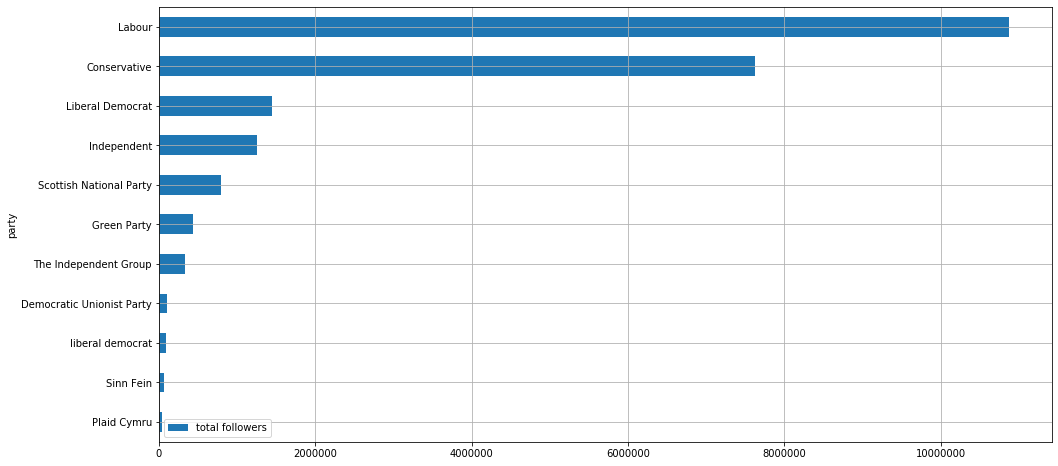

In [10]:
#create the plot and change type to "bar"
plot_num_foll = num_foll_grouped.sort_values(by = ["num_followers"], ascending = True).plot(kind = "barh", 
                                                                                            grid = True, figsize=(16, 8))
#change name of legend
plot_num_foll.legend(["total followers"])
#prevent scientific notation on x axis
plt.ticklabel_format(style= "plain", axis = "x")

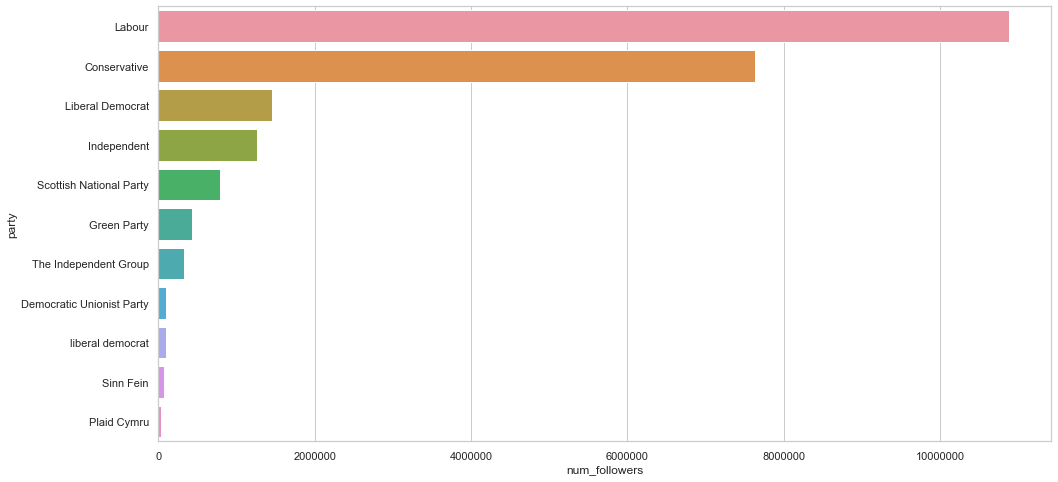

In [11]:
plt.figure(figsize=(16, 8))
#choose style
sns.set(style="whitegrid")
#draw plot
sns_num_foll = sns.barplot(x = "num_followers", y = "party", data = num_foll_grouped.sort_values(by = ["num_followers"], ascending = False).reset_index())
#prevent scientific notation
plt.ticklabel_format(style= "plain", axis = "x")

Bellow is added the percentage column, which shows the following of each party as a percentage. The two top parties have the 80% of the total number of followers and are indeed the most popular in Britain.

Although the Labour party is the most popular based on Twitter followers that does not indicate that it is the most popular party in general.

Here is an article based on polls which shows that at the moment the most popular party is the Conservative's one: https://www.bbc.com/news/uk-politics-49798197

Number of Twitter follwers does not show political preference. Twitter following could include "haters", or in this case supporters of other parties. Also, Twitter, as a social network, is mostly used by younger people. Elders may not use Twitter but they vote and they affect the ellection result. 

(note: one account can be following morre than one parties)

In [12]:
num_foll_grouped["percentage"] = num_foll_grouped["num_followers"]*100/num_foll_grouped["num_followers"].sum()
num_foll_grouped.sort_values(by = ["num_followers"], ascending = False)

,num_followers,percentage
party,,
Labour,10875748,47.162245
Conservative,7625332,33.066946
Liberal Democrat,1450824,6.291440
Independent,1255214,5.443185
Scottish National Party,788602,3.419741
Green Party,432193,1.874188
The Independent Group,333229,1.445034
Democratic Unionist Party,98177,0.425741
liberal democrat,92355,0.400494


## Part 3: Processing Text Content
### 3.1 Prepare a Profanity Set
* Reading the txt.
* Skipping the header part (24 first rows)
* Stripping terms of type and strength
* Deleting rows that do not contain abuse terms

In [13]:
url = "http://staffwww.dcs.shef.ac.uk/people/G.Gorrell/publications-materials/abuse-terms.txt"

#avoiding header of txt file
bad_words = pd.read_csv(url, skiprows=24, header=None)

#removing strength and type from dataframe
bad_words[0] = bad_words[0].apply(lambda x: x.split('\ttype')[0])
bad_words[0] = bad_words[0].apply(lambda x: x.split('\tstrength')[0])

#deleting rows that contain specific text
bad_words = bad_words[~bad_words[0].str.contains('TOTAL')]
bad_words = bad_words[~bad_words[0].str.contains('\*')]

#resetting index after deleting rows
bad_words = bad_words.reset_index(drop=True)

#renaming column
bad_words.columns = ["terms"]
bad_words.head()


,terms
0,a cock
1,anus
2,arse bandit
3,arsebandit
4,arsehole


### 3.2 Parse Tweets
* Reading file and creating dataframe with "class" and "tweet" columns
* Creating column "text-list" which contains a list of the words of every text in column "text"

In [14]:
#Reading file
dataframe = pd.read_csv("https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv",usecols = ["class", "tweet"])

#Renaming tweet column
dataframe = dataframe.rename({"tweet":"text"}, axis = "columns")

#Creating list of words in text column
dataframe['text-list'] = dataframe["text"].apply(lambda x: x.split())

pd.set_option('display.max_colwidth', -1)
dataframe.head()

,class,text,text-list
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,"[!!!, RT, @mayasolovely:, As, a, woman, you, shouldn't, complain, about, cleaning, up, your, house., &amp;, as, a, man, you, should, always, take, the, trash, out...]"
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,"[!!!!!, RT, @mleew17:, boy, dats, cold...tyga, dwn, bad, for, cuffin, dat, hoe, in, the, 1st, place!!]"
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,"[!!!!!!!, RT, @UrKindOfBrand, Dawg!!!!, RT, @80sbaby4life:, You, ever, fuck, a, bitch, and, she, start, to, cry?, You, be, confused, as, shit]"
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,"[!!!!!!!!!, RT, @C_G_Anderson:, @viva_based, she, look, like, a, tranny]"
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,"[!!!!!!!!!!!!!, RT, @ShenikaRoberts:, The, shit, you, hear, about, me, might, be, true, or, it, might, be, faker, than, the, bitch, who, told, it, to, ya, &#57361;]"


### 3.3 Count Abuse
* Finding common elements between each text-list and the bad_words set
* Adding a new column that counts the bad words that where both in the text and in the bad_words set

In [15]:
#turning the dataframe to list
bw = bad_words.values.flatten().tolist()

#creating a list of bad word counts
count = []
for index, row in dataframe.iterrows():
    count.append(len(set(row["text-list"]).intersection(bw)))

#making a column out of the count list
dataframe["count bad words"] = count

dataframe.head()

,class,text,text-list,count bad words
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,"[!!!, RT, @mayasolovely:, As, a, woman, you, shouldn't, complain, about, cleaning, up, your, house., &amp;, as, a, man, you, should, always, take, the, trash, out...]",0
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,"[!!!!!, RT, @mleew17:, boy, dats, cold...tyga, dwn, bad, for, cuffin, dat, hoe, in, the, 1st, place!!]",0
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,"[!!!!!!!, RT, @UrKindOfBrand, Dawg!!!!, RT, @80sbaby4life:, You, ever, fuck, a, bitch, and, she, start, to, cry?, You, be, confused, as, shit]",1
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,"[!!!!!!!!!, RT, @C_G_Anderson:, @viva_based, she, look, like, a, tranny]",1
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,"[!!!!!!!!!!!!!, RT, @ShenikaRoberts:, The, shit, you, hear, about, me, might, be, true, or, it, might, be, faker, than, the, bitch, who, told, it, to, ya, &#57361;]",1


Bellow are calculated some aggregates (mean, median, min, max, sum) of each class. The dataframe is first grouped by class.

In [16]:
groupedbyclass = dataframe.groupby(["class"])
groupedbyclass.agg(["mean", "median", "min", "max", "sum"])

count bad words                      
                 mean median min max    sum
class                                      
0      0.644056        1      0   10  921  
1      0.656331        1      0   5   12595
2      0.037713        0      0   2   157

### 3.4 Visualize Profanity

Figure: violin plot
* top of the black line is the maximum value per class
* plot is ticker where we have more observatiobs

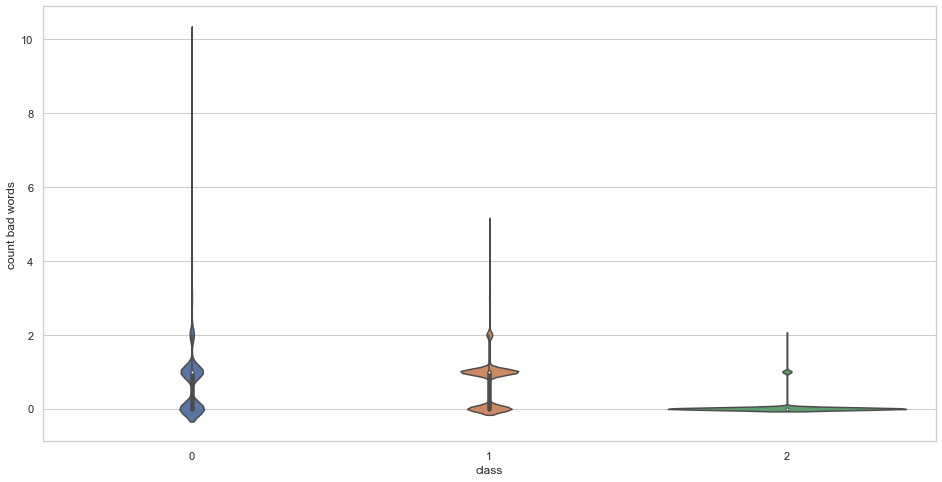

In [17]:
sns.set(style = "whitegrid")
plt.figure(figsize = (16, 8))
ax = sns.violinplot(x = dataframe["class"],y = dataframe["count bad words"])

Figure: boxplot
* top dot is the maximum value per class
* inside the box we have the most observations

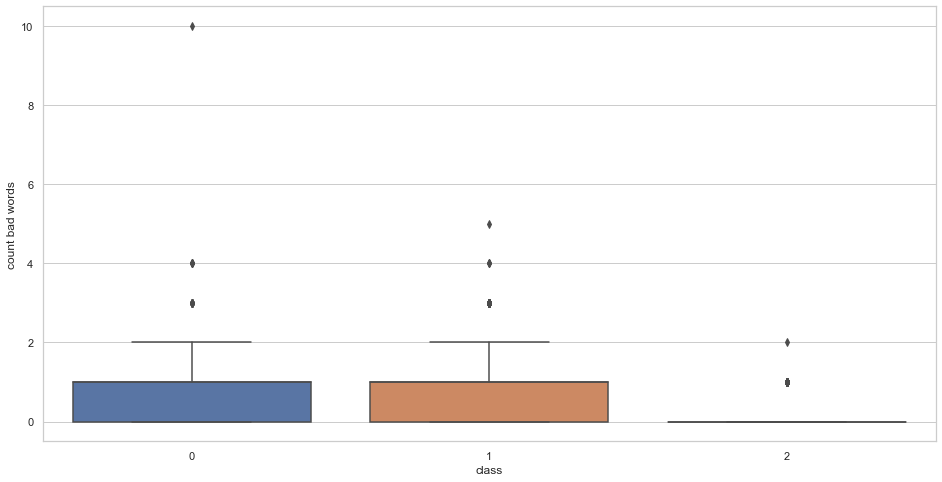

In [18]:
sns.set(style = "whitegrid")
plt.figure(figsize = (16, 8))
ax = sns.boxplot(x = dataframe["class"], y = dataframe["count bad words"])

Figure: strip plot
* each dot is an observation

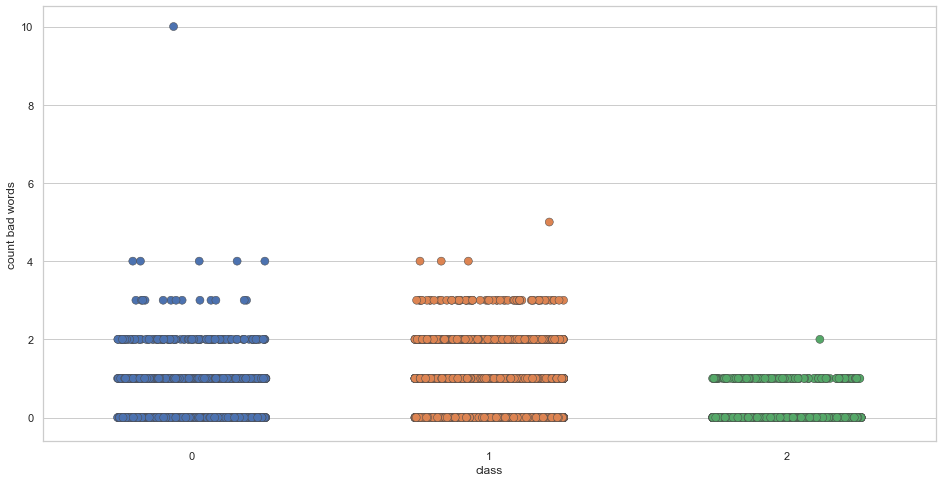

In [19]:
sns.set(style = "whitegrid")
plt.figure(figsize = (16, 8))
ax = sns.stripplot(x = dataframe["class"], y = dataframe["count bad words"],
                   linewidth = 0.5,
                   size = 8,
                   jitter = .25)

Figure: density plot

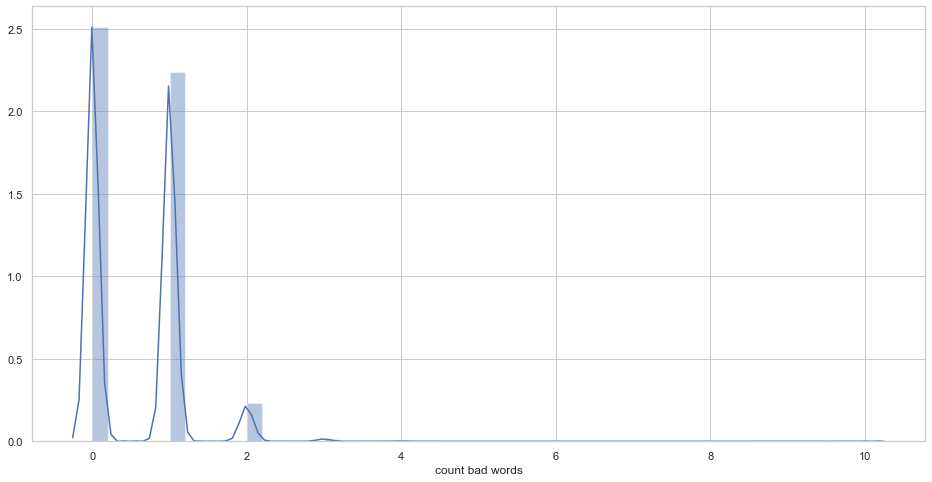

In [20]:
sns.set(style = "whitegrid")
plt.figure(figsize = (16, 8))
ax = sns.distplot(dataframe["count bad words"])

### 3.5 Explore Profanity per Class
* Using 3 Counter objects, 1 per class, to count the abuse terms

In [21]:
from collections import Counter
c0 = Counter()
c1 = Counter()
c2 = Counter()

for index, row in dataframe.iterrows():
    if row["class"] == 0:
        c0 += (Counter(set(row["text-list"]).intersection(bw)))
    elif row["class"] == 1:
        c1 += (Counter(set(row["text-list"]).intersection(bw)))   
    else:        
        c2 += (Counter(set(row["text-list"]).intersection(bw)))

print("class 0: 30 most common\n", c0.most_common(30))
print("class 1: 30 most common\n",c1.most_common(30))
print("class 2: 30 most common\n",c2.most_common(30))

class 0: 30 most common
 [('bitch', 150), ('faggot', 147), ('nigga', 92), ('nigger', 80), ('fag', 57), ('bitches', 50), ('niggers', 36), ('pussy', 36), ('kill', 29), ('queer', 23), ('dyke', 23), ('coon', 18), ('cunt', 17), ('retard', 15), ('dick', 14), ('spic', 12), ('die', 10), ('beaner', 8), ('whore', 6), ('gook', 6), ('wetback', 5), ('negro', 5), ('hang', 5), ('chink', 5), ('tranny', 5), ('homo', 4), ('rape', 4), ('asshole', 3), ('slut', 3), ('balls', 3)]
class 1: 30 most common
 [('bitch', 6211), ('bitches', 2467), ('pussy', 1618), ('nigga', 798), ('dick', 242), ('faggot', 178), ('cunt', 138), ('fag', 108), ('nigger', 99), ('kill', 80), ('pussies', 64), ('retard', 56), ('die', 40), ('dyke', 39), ('queer', 32), ('niggers', 26), ('hang', 23), ('twat', 23), ('negro', 22), ('tranny', 19), ('balls', 18), ('whore', 18), ('slut', 17), ('dumbass', 14), ('penis', 13), ('coon', 13), ('asshole', 12), ('fucker', 11), ('dicks', 10), ('asses', 9)]
class 2: 30 most common
 [('die', 13), ('coon', 